# Testing

This notebook is to test that a transmon behaves as expected when it is driven.

In [1]:
# imports
import numpy as np
from qutip import basis
from transmon_code.transmon import *
from transmon_code.simulate import *
from transmon_code.helpers import *

In [2]:
# define the transmon

tr = Transmon(n_levels=8, initial_state=0, Ω=5000, α=-100, RWA=False, dt=1/10000)
tr.X90_args = {'A': 7.348405182474674, 'Γ': 0.5002663076440171, 'ω': tr.Ω, 'A_DRAG': 0.007838355884812595}

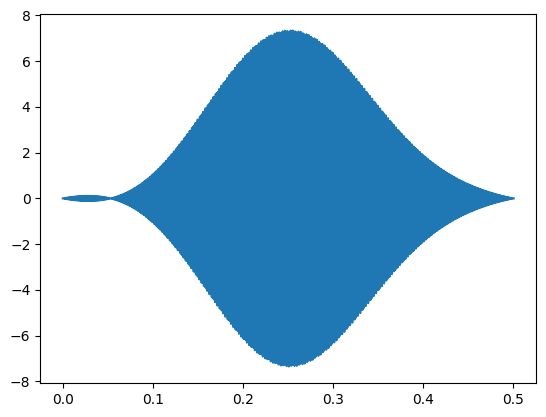

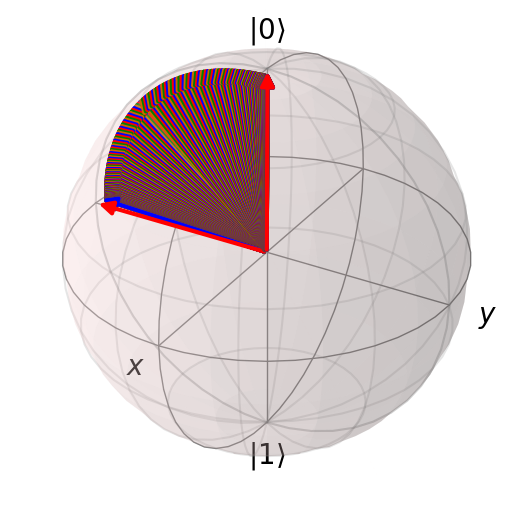

Fidelity:                    0.9996409974161314
Total measured error:        0.00035900258386856176
Leakage error:               0.0004121704112344095
Theoretical coherence error: 0.0
Error accounted for:         0.0004121704112344095
Error unaccounted for:       -5.316782736584772e-05


In [3]:
# test an X90 pulse from 0 to - (minus)

targ = (basis(tr.n_levels, 0)-1j*basis(tr.n_levels, 1)).unit()

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)

break_down_errors(tr, tr.X90_args, res[-1], f)

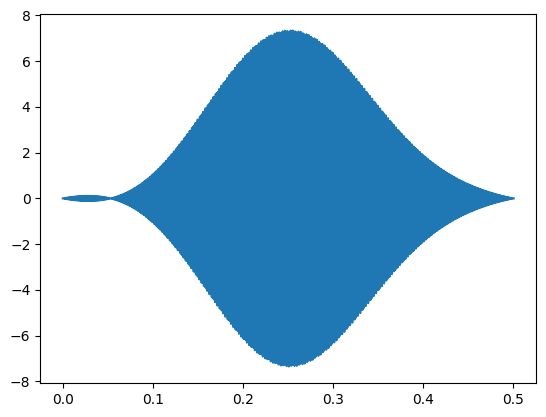

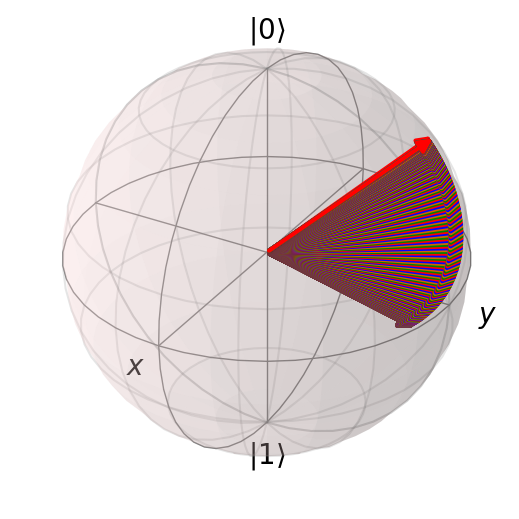

Fidelity:                    0.9994201712044611
Total measured error:        0.0005798287955388615
Leakage error:               0.0005472749916573016
Theoretical coherence error: 0.0
Error accounted for:         0.0005472749916573016
Error unaccounted for:       3.2553803881559895e-05


In [4]:
# test an X90 pulse on a random initial state

tr.ψ0 = expand(rand_ket(2), tr.n_levels)
targ = expand(calculate_target_state([U(gate_angles["X90"])], truncate(tr.ψ0), plot=False), tr.n_levels)

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)

break_down_errors(tr, tr.X90_args, res[-1], f)

tr.ψ0 = basis(tr.n_levels, 0)

In [ ]:
# test a noisy circuit by simulating each pulse individually

# define which two gates are to be tested
gate1 = "X90"
gate2 = "Z90"

# setup transmon and target
target = calculate_target_state([gate1, gate2], tr.ψ0)
target = expand(target, tr.n_levels)
tr.ψ0 = basis(tr.n_levels, 0)

# prep for plotting
b = Bloch()
b.make_sphere()
b.add_states(truncate(tr.ψ0))
b.add_states(truncate(target))

# gate 1
θ, φ, λ = gate_angles[gate1]
total_phase = 0

total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (φ-np.pi/2)

# gate 2
θ, φ, λ = gate_angles[gate2]
total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
results = simulate(tr, args, target=None, plot=False)

# final rotation to account for virtual z gates throughout
total_phase += (φ-np.pi/2)
result = rotate_z(results[-1], total_phase)

# final output

break_down_errors(tr, tr.X90_args, result, fidelity(result, target))

b.add_states(truncate(result))
b.render()
b.show()

Fidelity:                    0.9954869184740359
Total measured error:        0.00451308152596408
Leakage error:               0.00016497568801540234
Theoretical coherence error: 0.0
Error accounted for:         0.00016497568801540234
Error unaccounted for:       0.004348105837948678


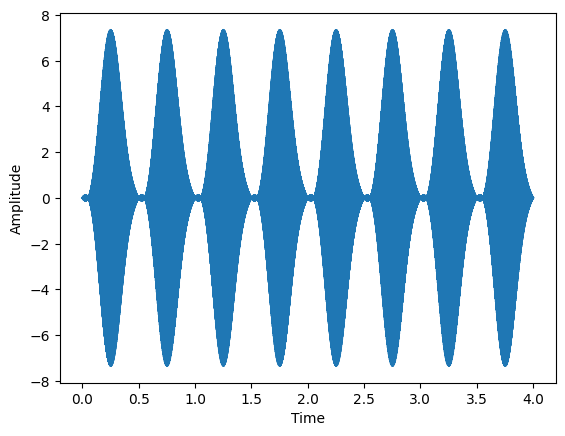

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.9909942 +5.23571954e-12j 0.00966072-9.27249301e-02j]
 [0.00966072+9.27249311e-02j 0.00884082+1.11651970e-09j]]

Converted to Hermitian matrix:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.9909942 +5.23571954e-12j 0.00966072-9.27249301e-02j]
 [0.00966072+9.27249311e-02j 0.00884082+1.11651970e-09j]]


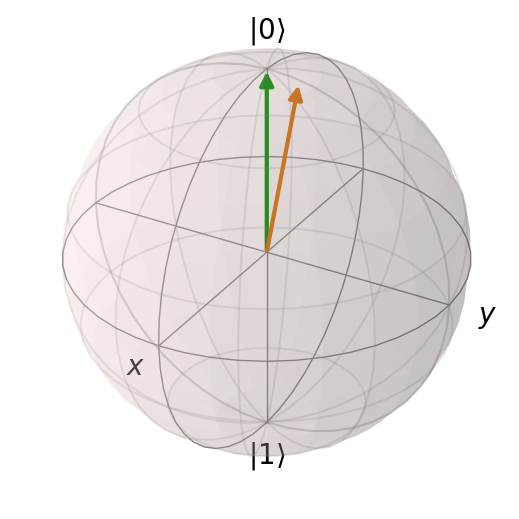

In [5]:
# test a circuit using simulate_circuit

# setup transmon and gates
tr.ψ0 = basis(tr.n_levels, 0)
gate1 = "X90"
gate2 = "Z90"
gate3 = "Z180"
gate4 = "Y90"

# define the circuit
c = [U(gate_angles[gate1]), U(gate_angles[gate2]), U(gate_angles[gate3]), U(gate_angles[gate4])]

# find target
targ = calculate_target_state(c, tr.ψ0)

# simulate
res, f = simulate_circuit(tr, c, noise=False, plot=True)